In [18]:
%matplotlib widget

from sklearn.datasets import load_diabetes
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [19]:
diabetes = load_diabetes(scaled=False) # disable Feature Scaling
data_unscaled = diabetes.data # (m x n) (examples x features)

severity = diabetes.target.reshape((-1,1)) # output of severity of diabetes or disease progression
# mx1

print(data_unscaled.dtype, severity.dtype) # show datatypes of input and output
print(data_unscaled.shape) # show shape of input
print(diabetes.feature_names) # show feature names associated with input
print(data_unscaled) # show unscaled data itself

float64 float64
(442, 10)
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
[[59.      2.     32.1    ...  4.      4.8598 87.    ]
 [48.      1.     21.6    ...  3.      3.8918 69.    ]
 [72.      2.     30.5    ...  4.      4.6728 85.    ]
 ...
 [60.      2.     24.9    ...  3.77    4.1271 95.    ]
 [36.      1.     30.     ...  4.79    5.1299 85.    ]
 [36.      1.     19.6    ...  3.      4.5951 92.    ]]


In [20]:
def predict(w,b,x):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = np.matmul(x, w) + b
    return prediction

In [21]:
def mse_cost(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = np.matmul(x, w) + b
    error = prediction - y
    error = error.reshape((-1)) # make it m (1d array) from mx1
    
    return np.dot(error, error) / (2*m)

In [22]:
def compute_gradient(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    # w = nx1
    # b = 1
    # x = mxn
    # y = mx1
    
    prediction = np.matmul(x, w) + b # mx1
    error = prediction - y # mx1
    
    xT = np.transpose(x) # nxm
    dw = np.matmul(xT, error) / m # nx1
    db = np.sum(error) / m # 1

    return dw, db

Showcase z score normalization feature scaling. Feature scaling is actually very easy with numpy. By taking mean and standard deviation of all columns (axis 0) we can just do a matrix subtract and division to get the data in one single step. This is a direct translation of the z score formula and makes it very simple to implement using numpy. Sigma is standard deviation and u is mean in the formula below.

$z=(x-u)/\sigma$

In [23]:
def feature_scale(data_unscaled):
    mu = np.mean(data_unscaled, axis=0)
    std = np.std(data_unscaled, axis=0)

    print("mean:",mu)
    print("std:",std)
    data_scaled = np.array(data_unscaled)
    data_scaled = (data_scaled - mu) / std
    # z score normalization
    
    return data_scaled

data = data_scaled = feature_scale(data_unscaled)
print("data:",data) # show scaled features

mean: [ 48.51809955   1.46832579  26.37579186  94.64701357 189.14027149
 115.43914027  49.78846154   4.07024887   4.64141086  91.260181  ]
std: [13.09419021  0.49899574  4.41312086 13.81562831 34.56888013 30.37865755
 12.91956242  1.28898929  0.52179929 11.48332247]
data: [[ 0.80050009  1.06548848  1.29708846 ... -0.05449919  0.41853093
  -0.37098854]
 [-0.03956713 -0.93853666 -1.08218016 ... -0.83030083 -1.43658851
  -1.93847913]
 [ 1.79330681  1.06548848  0.93453324 ... -0.05449919  0.06015558
  -0.54515416]
 ...
 [ 0.87686984  1.06548848 -0.33441002 ... -0.23293356 -0.98564884
   0.32567395]
 [-0.9560041  -0.93853666  0.82123474 ...  0.55838411  0.93616291
  -0.54515416]
 [-0.9560041  -0.93853666 -1.53537419 ... -0.83030083 -0.08875225
   0.06442552]]


Also I tried running gradient descent without feature scaling and the weights basically exploded to huge values and after just a few iterations, gradient descent stopped working. 
These are called exploding gradients.
Eventually, I just re-enabled feature scaling and gradient descent works nicely again.

w: [[ -0.31058692]
 [-11.28489499]
 [ 25.1561175 ]
 [ 15.32166059]
 [ -3.32594522]
 [ -5.28368843]
 [ -9.74582834]
 [  5.51432538]
 [ 22.30061411]
 [  3.55625362]]
b: 152.01209340808492


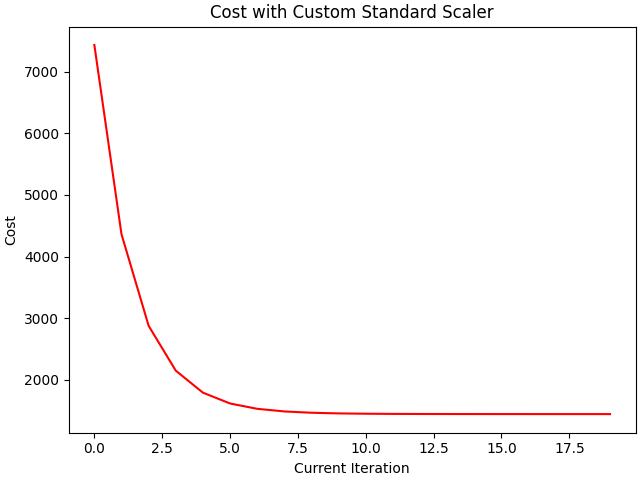

In [24]:
def gradient_descent(data, a, max_iterations=1000, title=""):
    m = data.shape[0] # number of training examples
    n = data.shape[1] # number of features
    
    w = np.zeros((n,1)) # n features
    b = 0
    # initialize model parameters to zeroes
    
    iteration = np.empty(0, dtype=np.uint)
    costs = np.empty(0)
    
    for i in range(max_iterations):
        dw, db = compute_gradient(w,b,data,severity)
        
        w-=a*dw
        b-=a*db
        # update the weights
        
        iteration = np.append(iteration, i)
        current_cost = mse_cost(w,b,data,severity)
        costs = np.append(costs, current_cost)
        # add to array for visualization
    
    # graph the cost after updating the model
    fig, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Current Iteration")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration, costs, color="r")

    print("w:",w)
    print("b:",b)
    return w,b
weights, intercept = gradient_descent(data, a=0.3, max_iterations=20, title="Cost with Custom Standard Scaler")

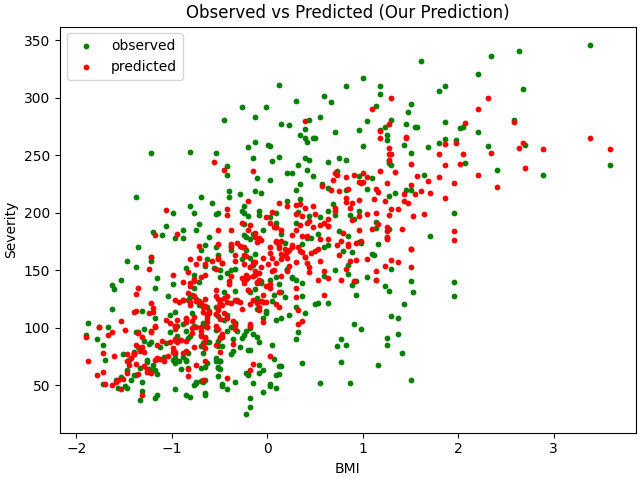

In [25]:
fig, ax = plt.subplots(layout='constrained')
    
ax.set_xlabel("BMI")
ax.set_ylabel("Severity")

ax.set_title("Observed vs Predicted (Our Prediction)")

bmi = data[:,2]
output = severity.reshape(-1)

custom_prediction = predict(weights,intercept,data)
ax.scatter(bmi, output, c="g", label="observed",s=10)
ax.scatter(bmi, custom_prediction, c="r", label="predicted",s=10)
ax.legend()

Only around 20 iterations are needed with feature scaling in this situation. It looks way too short. Let's scale with scikit and verify.

In [26]:
diabetes = load_diabetes(scaled=False) # disable Feature Scaling
data_unscaled = diabetes.data # (m x n) (examples x features)

severity = diabetes.target.reshape((-1,1)) # output of severity of diabetes or disease progression
# mx1

print(data_unscaled.dtype, severity.dtype) # show datatypes of input and output
print(data_unscaled.shape) # show shape of input
print(diabetes.feature_names) # show feature names associated with input
print(data_unscaled) # show unscaled data itself

float64 float64
(442, 10)
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
[[59.      2.     32.1    ...  4.      4.8598 87.    ]
 [48.      1.     21.6    ...  3.      3.8918 69.    ]
 [72.      2.     30.5    ...  4.      4.6728 85.    ]
 ...
 [60.      2.     24.9    ...  3.77    4.1271 95.    ]
 [36.      1.     30.     ...  4.79    5.1299 85.    ]
 [36.      1.     19.6    ...  3.      4.5951 92.    ]]


In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_unscaled)
print("mean:",scaler.mean_)
print("std:",np.sqrt(scaler.var_))
data_scaled_scikit = scaler.transform(data_unscaled)
print("data:",data_scaled_scikit)

mean: [ 48.51809955   1.46832579  26.37579186  94.64701357 189.14027149
 115.43914027  49.78846154   4.07024887   4.64141086  91.260181  ]
std: [13.09419021  0.49899574  4.41312086 13.81562831 34.56888013 30.37865755
 12.91956242  1.28898929  0.52179929 11.48332247]
data: [[ 0.80050009  1.06548848  1.29708846 ... -0.05449919  0.41853093
  -0.37098854]
 [-0.03956713 -0.93853666 -1.08218016 ... -0.83030083 -1.43658851
  -1.93847913]
 [ 1.79330681  1.06548848  0.93453324 ... -0.05449919  0.06015558
  -0.54515416]
 ...
 [ 0.87686984  1.06548848 -0.33441002 ... -0.23293356 -0.98564884
   0.32567395]
 [-0.9560041  -0.93853666  0.82123474 ...  0.55838411  0.93616291
  -0.54515416]
 [-0.9560041  -0.93853666 -1.53537419 ... -0.83030083 -0.08875225
   0.06442552]]


In [28]:
print(data_scaled - data_scaled_scikit) # show scaled differences between 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Nice. This shows us that our custom std scaler is the same as the one scikit provides. Now let's do gradient descent again.

w: [[ -0.31058692]
 [-11.28489499]
 [ 25.1561175 ]
 [ 15.32166059]
 [ -3.32594522]
 [ -5.28368843]
 [ -9.74582834]
 [  5.51432538]
 [ 22.30061411]
 [  3.55625362]]
b: 152.01209340808492


(array([[ -0.31058692],
        [-11.28489499],
        [ 25.1561175 ],
        [ 15.32166059],
        [ -3.32594522],
        [ -5.28368843],
        [ -9.74582834],
        [  5.51432538],
        [ 22.30061411],
        [  3.55625362]]),
 152.01209340808492)

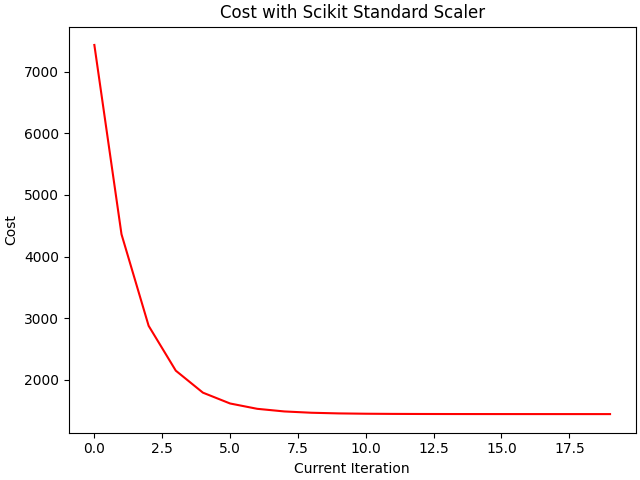

In [29]:
gradient_descent(data_scaled_scikit, a=0.3, max_iterations=20, title="Cost with Scikit Standard Scaler")

This drop is insanely surprising. I don't understand why it could learn this fast in only 10 iterations.

In [30]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(data_scaled_scikit, severity)
scikit_predict = reg.predict(data_scaled_scikit).reshape(-1)

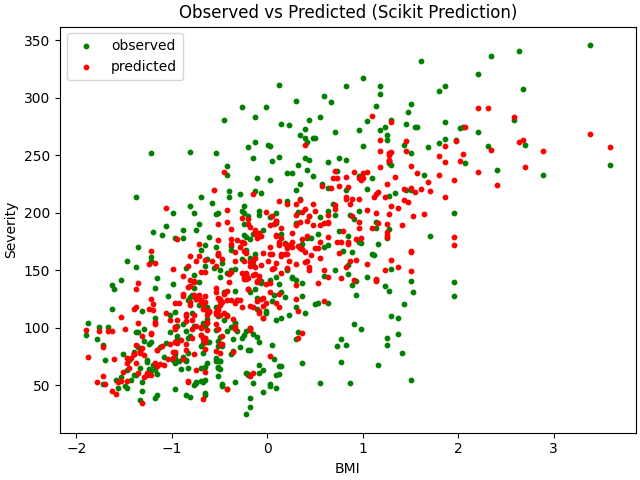

In [31]:
fig, ax = plt.subplots(layout='constrained')
    
ax.set_xlabel("BMI")
ax.set_ylabel("Severity")

ax.set_title("Observed vs Predicted (Scikit Prediction)")

bmi = data_scaled_scikit[:,2]
output = severity.reshape(-1)

ax.scatter(bmi, output, c="g", label="observed",s=10)
ax.scatter(bmi, scikit_predict, c="r", label="predicted",s=10)
ax.legend()

In [32]:
diff = custom_prediction - scikit_predict
print("Total Diff:",np.sum(diff))
print("Avg Diff:",np.mean(diff))

Total Diff: -23715.383422916493
Avg Diff: -0.12139075481110385


Average Difference between ours and scikit is close to 0. This shows that our custom model actually works properly and the 20 iterations to convergence is no joke. This most likely means that the gradients are very steep and huge and we're on a high slope mountain. Let's see the cost contour graph with bmi, intercept as the axis.

In [33]:
x = data
y = severity

def grid_cost(w, b):
    tw = np.array(weights)
    tw[2] = w # switch out learned w for bmi w
    
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = np.matmul(x, tw) + b
    error = prediction - y
    error = error.reshape((-1)) # make it m (1d array) from mx1
    
    return np.dot(error, error) / (2*m)

delta = 1000
i = np.linspace(-delta, delta, 100)
j = np.linspace(-delta, delta, 100)

xv, yv = np.meshgrid(i, j)

cost_func = np.vectorize(grid_cost)
z = cost_func(xv, yv)

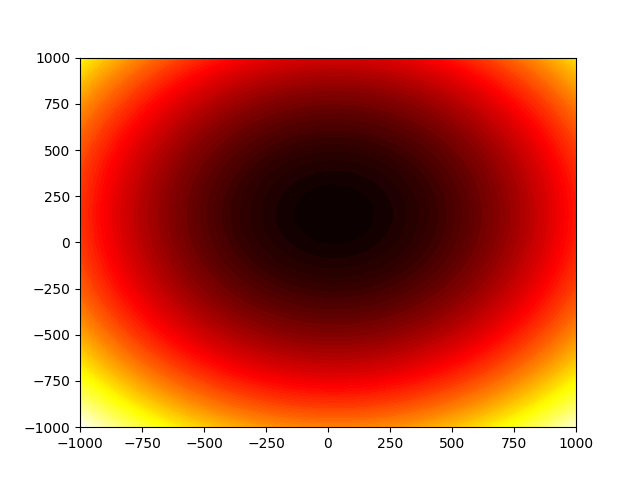

In [34]:
fig, ax = plt.subplots()
ax.contourf(i, j, z, levels=100, cmap = plt.cm.hot)

From this contour, it looks like the minimum cost is around the origin which is very surprising to say. All of our weights are with 50 units from the origin. Only the intercept is around 150 far from the origin. So we already started at the very bottom hence we needed only ~10 iterations for convergence.